# Определение стоимости автомобилей

# Determining the cost of cars

Сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.
Построим модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:

- качество предсказания;
- время обучения модели;
- время предсказания модели.

________________________________________________________________________________________________________________________________

A used car service is developing an app to attract new customers. It will show you the market value of your car.
Let's build a model that can determine it. We have at our disposal data on the technical characteristics, equipment and prices of other cars.

Criteria that are important to the customer:

- quality of prediction;
- model training time;
- model prediction time.

## Подготовка данных

## Data preparation

### Загрузка данных и библиотек

In [3]:
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import Pool, CatBoostRegressor, cv
from sklearn.tree import DecisionTreeRegressor 
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [ ]:
autos_data = pd.read_csv('autos.csv')
autos_data.info()
autos_data.head()

Сразу уберем данные, не связанных с влиянием на стоимость автомобиля, и будем анализировать непосредственно нужные нам столбцы.

В выборе руководствуемся следующей логикой:

- VehicleType. Типа кузова автомобиля явно влияет на стоимость и общий функционал.
- Gearbox. Наличие автоматической коробки передач обычно повышает стоимость автомобиля.
- Power. Мощность в лоашдиных силах (далее л.с.), судя по реальным данным, напрямую влияют на цену.
- Kilometer. пройденный километраж, чем больше километров пройдено автомобилем, тем ниже его стоимость.
- Brand. Известность товарной марки автомобиля также напрямую влияет на его стоимость.
- Repaired. Показатель того, был ли автомобиль в ремонте.
- RegistrationYear. Год регистрации автомобиля, говорит о его возрасте. Чем выше возраст автомобиля, тем ниже его стоимость.
- Model. Влияет на стоимость автомобиля аналогично товарной марке.
- Price. Собственно, целевой признак.

________________________________________________________________________________________________________________________________

We will immediately remove the data that is not related to the impact on the cost of the car, and we will analyze the columns we need directly.

In choosing, we are guided by the following logic:

-VehicleType. The type of car body clearly affects the cost and overall functionality.
- Gearbox. The presence of an automatic transmission usually increases the cost of the car.
- power. Power in horsepower (hereinafter referred to as hp), judging by real data, directly affects the price.
- Kilometer. mileage traveled, the more kilometers traveled by the car, the lower its cost.
- Brand. The popularity of the brand of the car also directly affects its value.
- Repaired. An indication of whether the vehicle has been repaired.
- RegistrationYear. The year of registration of the car indicates its age. The older the car, the lower its value.
- Model. Affects the cost of the car in a similar way to the brand name.
- Price. Actually, the target sign.

In [3]:
autos_data_2 = autos_data.drop(['LastSeen','PostalCode','NumberOfPictures','DateCreated','FuelType','RegistrationMonth','DateCrawled'], axis=1)

In [4]:
autos_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   Brand             354369 non-null  object
 8   Repaired          283215 non-null  object
dtypes: int64(4), object(5)
memory usage: 24.3+ MB


### Предобработка данных

### Data preprocessing

Типы данных соответсвуют их наполнению.

Ознакомимся с уникальными значениями столбцов.

The data types correspond to their content.

Let's get acquainted with the unique values of the columns.

In [5]:
for col in autos_data_2.select_dtypes(include='object').columns:
    print('Уникальные значения столбца', col)
    print(autos_data_2[col].unique(), '\n')

Уникальные значения столбца VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 

Уникальные значения столбца Gearbox
['manual' 'auto' nan] 

Уникальные значения столбца Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_re

Пропущенные модели не представляется возможным восстановить, поэтому пометим их как other (другие).

Missing models cannot be restored, so we will mark them as other (others).

In [6]:
autos_data_2.fillna({'Model':'other'}, inplace=True)

Существуют пропущенные значения, которые необходимо заполнить. Автоматическая коробка передач больше распространена в развитых странах, поэтому заполним пропущенные Gearbox значения в на auto.

There are missing values that need to be filled in. Automatic transmission is more common in developed countries, so let's fill in the missing Gearbox values in auto.

In [7]:
autos_data_2['Gearbox'].fillna('auto', inplace=True)

Пропуски в Repaired скорее всего можно трактовать как отсутствие ремонта.

Omissions in Repaired can most likely be interpreted as a lack of repair.

In [8]:
autos_data_2['Repaired'].fillna('no', inplace=True)

С заменой пропущенных в VehicleType ситуация сложнее. Есле заполнить их наиболее распространенным значением, то это сильно повлияет на итоговые статистики. Поэтому заполним их значением other, возможно модели не поддавались классификации.

With the replacement of missing ones in VehicleType, the situation is more complicated. If you fill them with the most common value, then this will greatly affect the final statistics. Therefore, we fill them with the value other, perhaps the models did not lend themselves to classification.

In [9]:
autos_data_2['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [10]:
autos_data_2['VehicleType'].isna().value_counts()

False    316879
True      37490
Name: VehicleType, dtype: int64

In [11]:
autos_data_2['VehicleType'].fillna('another', inplace=True)

Проверяем числовые данные на предмет наличия нулевых значений и пропусков.

We check the numerical data for the presence of zero values and gaps.

In [12]:
for col in autos_data_2.select_dtypes(include='int64').columns:
    print('Пропуски столбца', col)
    print(autos_data_2[col].isna().sum(), '\n') 

Пропуски столбца Price
0 

Пропуски столбца RegistrationYear
0 

Пропуски столбца Power
0 

Пропуски столбца Kilometer
0 



Посмотрим распределение значений.

Let's look at the distribution of values.

<AxesSubplot:>

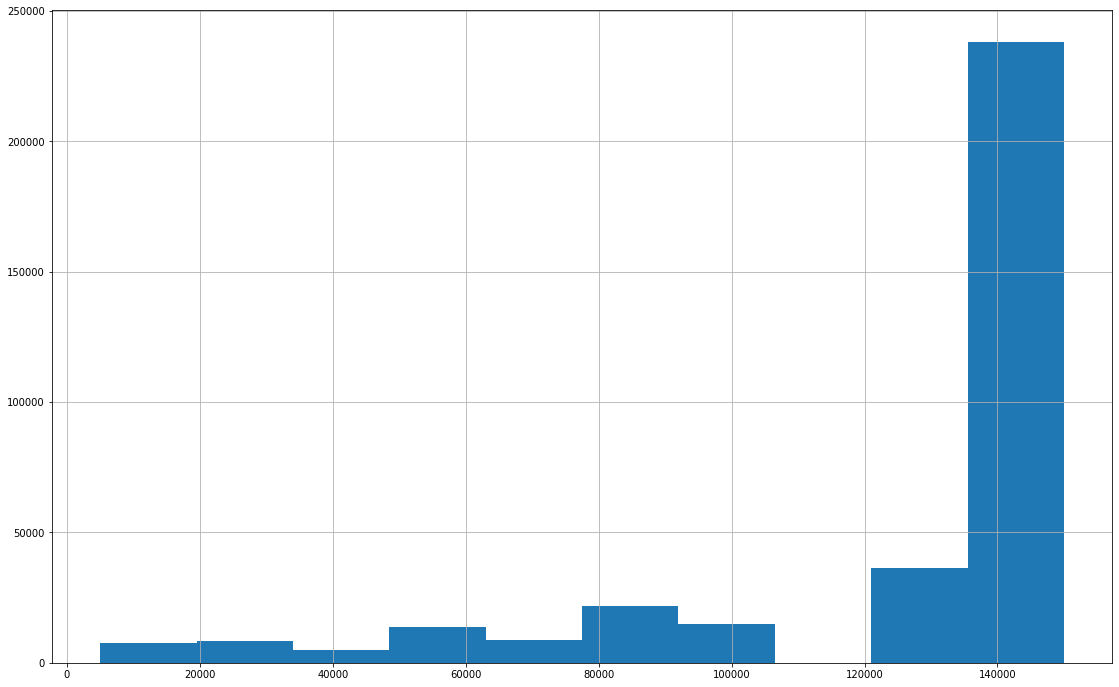

In [13]:
autos_data_2['Kilometer'].hist(figsize=(19,12))

<AxesSubplot:>

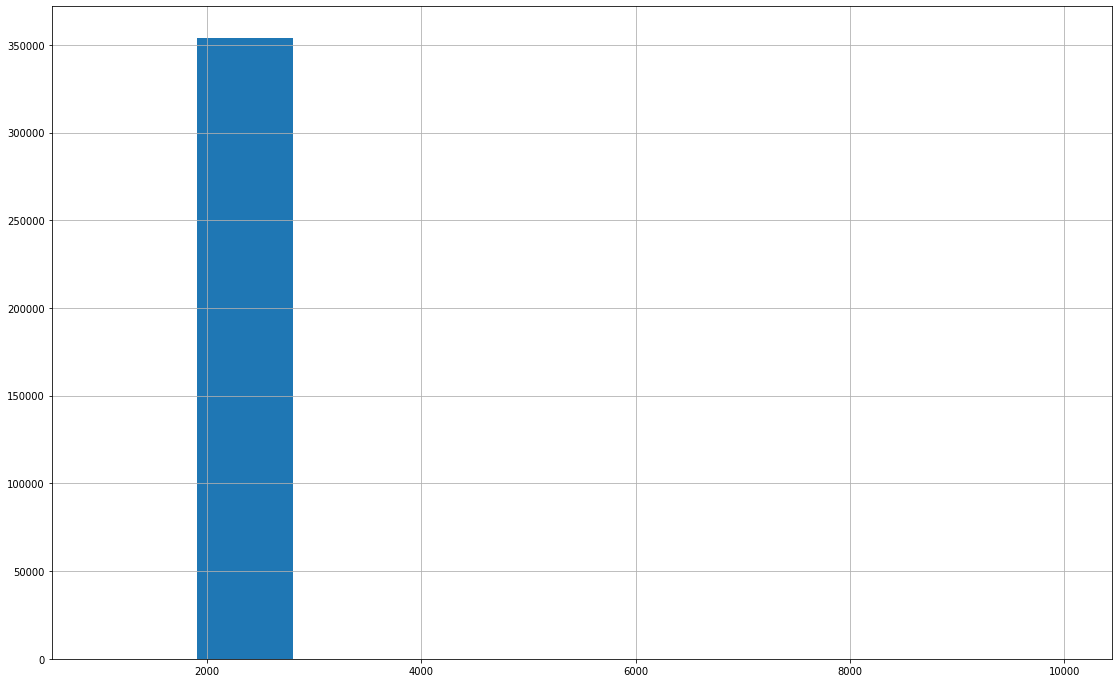

In [14]:
autos_data_2['RegistrationYear'].hist(figsize=(19,12))

<AxesSubplot:>

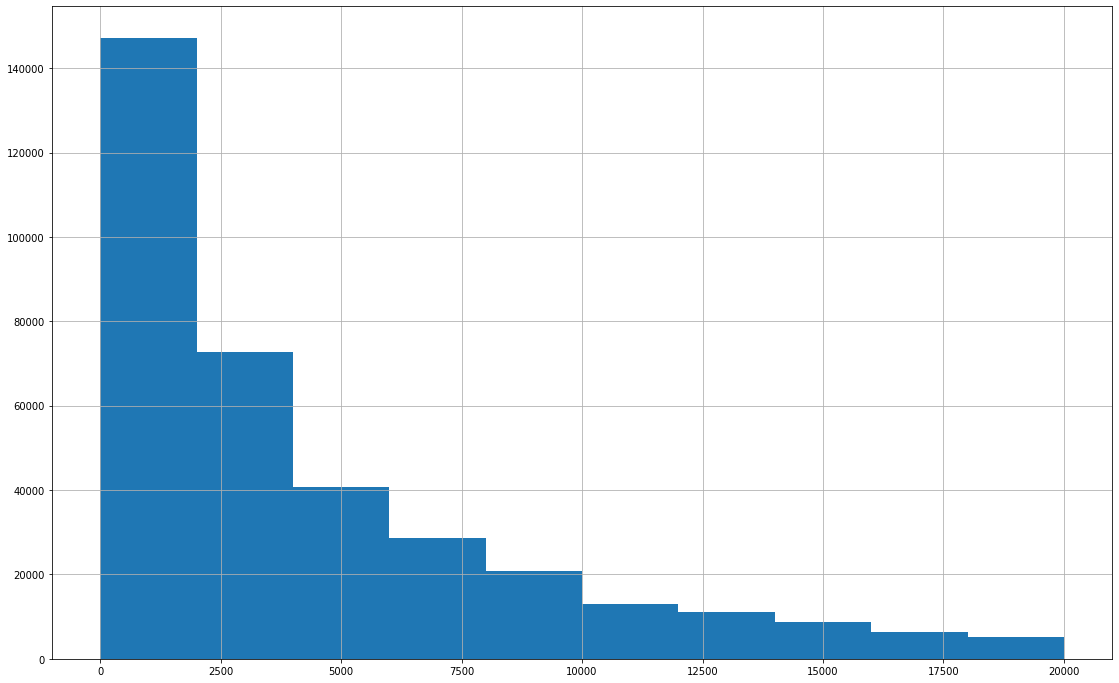

In [15]:
autos_data_2['Price'].hist(figsize=(19,12))

<AxesSubplot:>

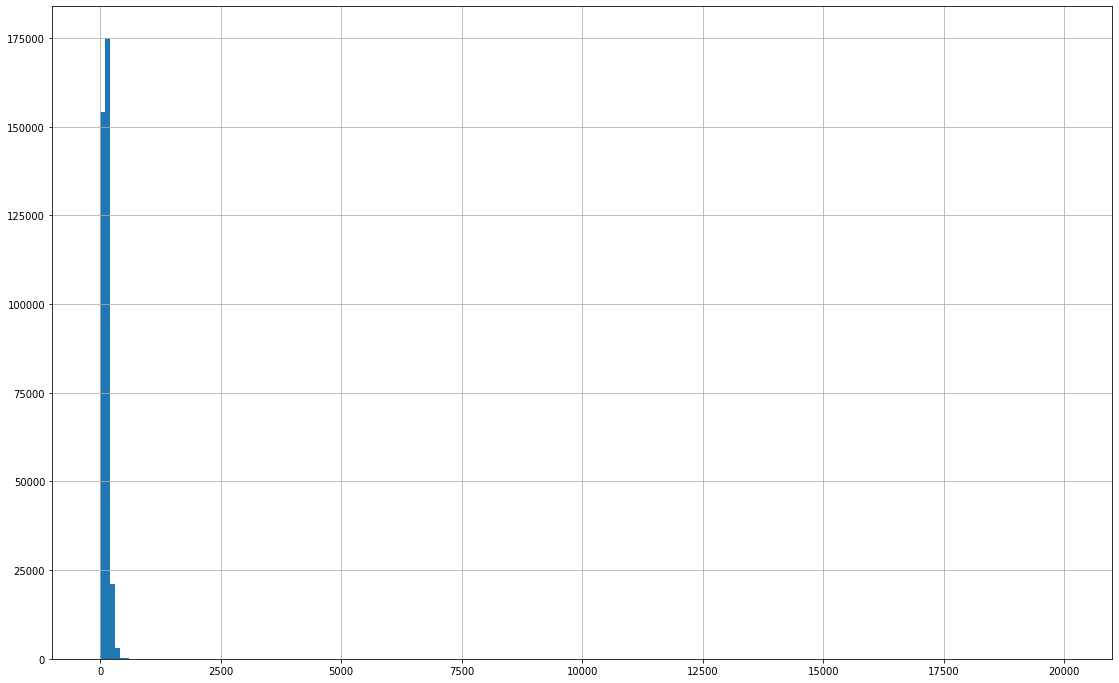

In [16]:
autos_data_2['Power'].hist(bins=200, figsize=(19,12))

In [17]:
for col in autos_data_2.select_dtypes(include='int64').columns:
    print('Основные статистики столбца', col)
    print(autos_data_2[col].describe(),  '\n')

Основные статистики столбца Price
count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64 

Основные статистики столбца RegistrationYear
count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64 

Основные статистики столбца Power
count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64 

Основные статистики столбца Kilometer
count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilome

Проверим целевую переменную.

Let's check the target variable.

In [18]:
autos_data_2['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

Присутствуют нулевые значения, избавимся от них.

There are null values, get rid of them.

In [19]:
autos_data_2 = autos_data_2.query('Price > 0')

Столбец Kilometer не нуждается в изменениях. 

Минимальная мощность среди указанных моделей составялет 100 л.с., максимальная - 450 л.с. Наименьшим годом обозначим самую старую модель из присутствующих, Golf 1974 г, а максимальным - годом наиболее позднего размещения объявления в изначальных данных.
________________________________________________________________________________________________________________________________
The Kilometer column does not need to be changed.

The minimum power among these models is 100 hp, the maximum is 450 hp. The smallest year is the oldest model present, the 1974 Golf, and the longest year is the year of the latest announcement in the original data.

In [20]:
pd.to_datetime(autos_data['DateCrawled']).max()

Timestamp('2016-04-07 14:36:58')

In [21]:
autos_data_2 = autos_data_2.query('1973 < RegistrationYear < 2017')

In [22]:
autos_data_2 = autos_data_2.query('99 < Power < 451') 

Наконец, удалим дупликаты.

Finally, we will remove the duplicates.

In [23]:
autos_data_2.drop_duplicates(inplace=True)

### Выводы по 1 этапу

### Conclusions on stage 1

- Загружены данные
- Отобраны те факторы, которые влияеют на вариативность целевой переменной
- Данные проанализированы на наличие пропусков и аномалий
- Пропуски были заполнены, аномалии и дупликаты удалены
________________________________________________________________________________________________________________________________
- Loaded data
- Selected those factors that affect the variability of the target variable
- Data analyzed for gaps and anomalies
- Gaps have been filled in, anomalies and duplicates removed

## Обучение моделей

## Model training

### Подготовка признаков и разбивка на выборки

### Feature preparation and sampling

Перед нами стоит задача регрессии. На данном этапе мы будем использовать и сравнивать те модели, которые наиболее часто применяются для решения данного типа задач - модель случайного леса, а также LightGBM и CatBoostCRegressor (предлагаются по заданию и пройденной теории).

Начнем с выделения целевой переменной и признаков.
________________________________________________________________________________________________________________________________
We are faced with the task of regression. At this stage, we will use and compare those models that are most often used to solve this type of problem - the random forest model, as well as LightGBM and CatBoostCRegressor (offered according to the task and the theory passed).

Let's start by highlighting the target variable and features.

In [24]:
target = autos_data_2['Price']#Выделим целевую перменную

features = autos_data_2.drop('Price', axis=1)#Выделим признаки

Разобьем на выборки.

Let's break it down into samples.

In [25]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.35, 
                                                                              random_state=161222)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.35, 
                                                                              random_state=161222) #Разобьем данные на выборки

In [26]:
print(features_train.shape, features_valid.shape, features_test.shape)

(104108, 8) (36438, 8) (19621, 8)


In [27]:
print(target_train.shape, target_valid.shape, target_test.shape) 

(104108,) (36438,) (19621,)


Для обучения модели необходимо перевести категориальные признаки в численные. Используем для этого метод OneHotEncoder.

To train the model, it is necessary to convert categorical features into numerical ones. We use the OneHotEncoder method for this.

In [28]:
features_train_ohe = features_train.copy()
features_valid_ohe = features_valid.copy()
features_test_ohe = features_test.copy()

columns_ohe =  ['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'Brand', 'Repaired']
 
encoder_ohe = OneHotEncoder(handle_unknown = 'ignore')
encoder_ohe.fit(features_train_ohe[columns_ohe])
 
features_ohe_train = pd.DataFrame(encoder_ohe.transform(features_train_ohe[columns_ohe]).toarray(),
                                  index=features_train_ohe.index)
features_ohe_valid = pd.DataFrame(encoder_ohe.transform(features_valid_ohe[columns_ohe]).toarray(),
                                  index=features_valid_ohe.index)
features_ohe_test = pd.DataFrame(encoder_ohe.transform(features_test_ohe[columns_ohe]).toarray(),
                                  index=features_test_ohe.index)

In [29]:
features_ohe_train.columns = encoder_ohe.get_feature_names(columns_ohe)
features_ohe_valid.columns = encoder_ohe.get_feature_names(columns_ohe)
features_ohe_test.columns = encoder_ohe.get_feature_names(columns_ohe)
 
features_train_ohe = pd.concat([features_train_ohe, features_ohe_train], axis=1)
features_valid_ohe = pd.concat([features_valid_ohe, features_ohe_valid], axis=1)
features_test_ohe = pd.concat([features_test_ohe, features_ohe_valid], axis=1)
 
features_train_ohe = features_train_ohe.drop(columns_ohe, axis=1)
features_valid_ohe = features_valid_ohe.drop(columns_ohe, axis=1)
features_test_ohe = features_test_ohe.drop(columns_ohe, axis=1)

### Сравнение моделей

### Compare models

Приступим к сравнению моделей. Начнем с наиболее простого варианта - модели случайного леса.

Проведем два эксперимента.

Проверим модель на принаках, закодированных по методу OHE.
На признаках, закодированных по методу OE.
________________________________________________________________________________________________________________________________
Let's start comparing models. Let's start with the simplest option - the random forest model.

Let's do two experiments.

Let's check the model on features coded using the OHE method.
On the signs coded according to the OE method.

In [ ]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[19072020]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5

In [ ]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[19072020]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

Обучение на OHE данных дало похожий результат, что и порядковое кодирование признаков. Занесем оба эксперимента в финальную таблицу.

Training on OHE data gave a similar result as ordinal feature coding. Let's put both experiments in the final table.

Наилучший результат получен при следующих параметрах: max_depth=16, min_samples_leaf=7, min_samples_split=5, RMSE = 2262. Теперь рассмотрим работу регрессора CatBoostClassifier.

The best result was obtained with the following parameters: max_depth=16, min_samples_leaf=7, min_samples_split=5, RMSE = 2262. Now let's consider the operation of the CatBoostClassifier regressor.

In [ ]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[19072020],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

In [ ]:
%%time

regressor = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=19072020, 
                              verbose=False, 
                              cat_features=['VehicleType','FuelType','Brand','Model']) 
print('# Train for root_mean_squared_error')
print()
cv_RMSE_CBR_original = (cross_val_score(regressor,
                                original_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_original)

Наилучший результат достигнут при iterations=300, RMSE = 1901. Далее рассмотрим регрессор LightGBM.

The best result was achieved with iterations=300, RMSE = 1901. Next, consider the LightGBM regressor.

In [ ]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[19072020]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

Достигнут наилучший результат RMSE = 1908

Achieved the best result RMSE = 1908

### Вывод по 2 этапу

### Conclusion on stage 2

Было проведено сравнение работы трех моделей регрессоров - модели случайного леса, LightGBM и CatBoostRegressor. По требуемым параметрам (качество предсказания, время обучения, время предсказания) наилучшей моделью выступает CatBoostRegressor с показателем RMSE = 1901.
________________________________________________________________________________________________________________________________
The work of three regressor models was compared - the random forest model, LightGBM and CatBoostRegressor. According to the required parameters (prediction quality, training time, prediction time), the best model is CatBoostRegressor with RMSE = 1901.

## Проверка лучшей модели

## Checking the best model

In [ ]:
%%time

cat_features_n=['VehicleType', 'Gearbox', 'Model', 'Kilometer', 'Brand', 'Repaired']

cat_model = CatBoostRegressor(loss_function='RMSE', iterations=300, learning_rate=0.5, random_state=161222, cat_features=cat_features_n)

cat_model.fit(features_test, target_train, cat_features=cat_features_n, verbose=10)

In [ ]:
%%time

pred_valid = cat_model.predict(features_test) 

## Итоги

## Results

В ходе работы было выполнено:

1. Загружены данные и проведена их предобработка (удалены дупликаты, устранены аномалии, заполнены пропуски).
2. Выполнено сравнение трех выбранных моделей.
3. Выбрана лучшая модель по результатам метрики RMSE и времени обучения.

Наилучшей моделью для решения данной задачи по итогам является CatBoostRegressor с показателем RMSE = 1901, временем обучения 25.8 s и временем предсказания 55.1 ms.
________________________________________________________________________________________________________________________________
In the course of the work, the following was done:

1. Data loaded and pre-processed (duplicates removed, anomalies eliminated, gaps filled).
2. Three selected models were compared.
3. The best model was selected based on the results of the RMSE metric and training time.

Based on the results, the best model for solving this problem is CatBoostRegressor with RMSE = 1901, training time 25.8 s and prediction time 55.1 ms.